# Capacity Building
## Prerequisites
- Some basic understanding of Python variables, data types, looping, conditionals and functions will be of benefit.
- Completion of  01-basic-model.ipynb
## Data inputs
### Imports

Let's import some modules. A module is a library of Python code that we can leverage to provide useful functionality.<br> These may be part of the standard Python library, or be external packages

In [1]:
# Install the summer package
# Pip is Python's standard package manager

%pip install summerepi

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Python standard library imports come first
from datetime import datetime, timedelta 
from typing import List

# Then external package imports
import pandas as pd
import numpy as np
from summer import CompartmentalModel
from matplotlib import pyplot as plt 

plt.style.use("ggplot")

# Define constants
GITHUB_MOH = (
    "https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/"
)

MOH_FILES = [
    "cases_malaysia",
    "deaths_malaysia",
    "hospital",
    "icu",
    "cases_state",
    "deaths_state",
]

COVID_BASE_DATE = datetime(2019, 12, 31)

region = "Malaysia"

### Utility functions

In [3]:
def fetch_mys_data(base_url: str, file_list: List[str]) -> pd.DataFrame:
    """
    Request files from MoH and combine them into one data frame.
    """
    a_list = []
    for file in file_list:
        data_type = file.split('_')[0]
        df = pd.read_csv(base_url + file + ".csv")
        df['type']  = data_type
        a_list.append(df)
    df = pd.concat(a_list) 
    
    return df

Now call the function and pass it the MoH url.<br> Well done! We have scraped Malaysia's entire national and regional Covid-19 dataset into one dataframe

In [4]:
df = fetch_mys_data(GITHUB_MOH, MOH_FILES)

# Some preprocessing steps
df.loc[df['state'].isna(), 'state'] = 'Malaysia' 
df['date'] = pd.to_datetime(df['date'])
df['date_index'] = (df['date'] - COVID_BASE_DATE).dt.days

# Configure mask for analysis.
mask = (df['state'] == region) & (df['type'] == 'cases')

Let's also download the latest population distributions from the MoH GitHub repository.

In [5]:
population_url = 'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/static/population.csv'
df_pop = pd.read_csv(population_url)
initial_population = df_pop[df_pop['state'] == region]['pop'][0]

## Build a model

In [6]:
start_date = datetime(2021,1,1)  # Define the start date
end_date = start_date + timedelta(days=300)  # Define the duration

# Integer representation of the start and end dates.
start_date_int = (start_date - COVID_BASE_DATE).days
end_date_int = (end_date- COVID_BASE_DATE).days

Extract the target data from the MoH dataframe.

In [7]:
target = df[mask][start_date_int: end_date_int]['cases_new']
x_range = range(start_date_int, end_date_int)  # Create a integer range from the start date to the end date

In [8]:
# Define the model
malaysia_model = CompartmentalModel(
    times=(start_date_int, end_date_int),
    compartments=["S", "E", "I", "R"],
    infectious_compartments=["I"],
    timestep=1.0,
)

malaysia_model.set_initial_population(distribution={"S": initial_population - 100, "E": 0, "I": 100})

### Time varying parameters (transition flow)
The rate at which people transition can be set as a constant, or it can be defined as a function of time. This is the case of all of the flows: every parameter can be a constant or a function of time. Parameters also take a ‘computed_values’ argument, which is a dictionary of values computed at runtime that is not specific to any individual flow.

In [9]:
def recovery_rate(time, computed_values):
    """
    Returns the recovery rate for a given time.
    People recover faster after day ten due to a magic drug.
    """
    if time < 517: # half way through our
        return 0.1
    else:
        return 0.4

Infection frequency flow

This flow can be used to model infections using frequency-dependent disease transmission.<br>
In unstratified models, the frequency-dependent infection flow rate (the number of people infected per time unit) is calculated as:<br>

```python3
# contact_rate: Rate at which contact happens between people and results in a transmission
# num_source: Number of people in the (susceptible) source compartment
# num_infectious: Number of people infected
# num_pop: Total number of people in the population

force_of_infection = contact_rate * num_infectious / num_pop
flow_rate = force_of_infection * num_source
```

### Adding inter-compartmental flows 

Now, let's add some flows for people to transition between the compartments. These flows will define the dynamics of our infection. We will add:

- an infection flow from S to E (using frequency-dependent transmission)
- an exposed individual becomes infected E to I.
- a recovery flow from I to R

In [10]:
# Susceptible people can get infected.
malaysia_model.add_infection_frequency_flow(name="infection", contact_rate=0.18, source="S", dest="E")

# Expose people transition to infected.
malaysia_model.add_transition_flow(name="progression", fractional_rate=1/15, source="E", dest="I")

# Infectious people recover.
malaysia_model.add_transition_flow(name="recovery", fractional_rate=recovery_rate, source="I", dest="R")

# Importantly, we will also request an output for the 'progression' flow, and name this 'notifications'
# This will be available after a model run using the get_derived_outputs_df() method

malaysia_model.request_output_for_flow("notifications", "progression")

# Inspect the new flows, which we just added to the model.
malaysia_model._flows



[<InfectionFrequencyFlow 'infection' from S to E>,
 <TransitionFlow 'progression' from E to I>,
 <TransitionFlow 'recovery' from I to R>]

### Running the model

Now we can calculate the outputs for the model over the requested time period. 
The model calculates the compartment sizes by solving a system of differential equations (defined by the flows we just added) over the requested time period.

In [11]:
malaysia_model.run()

### Print the model outputs

The recommended way to view the model's results is via the get_outputs_df() method

In [12]:
mm_outputs_df = malaysia_model.get_outputs_df()
mm_outputs_df

,S,E,I,R
367.0,3.265700e+07,0.000000,100.000000,0.000000
368.0,3.265698e+07,16.594658,91.033272,9.534984
369.0,3.265697e+07,30.723277,83.890509,18.267380
370.0,3.265695e+07,42.833886,78.256589,26.363318
371.0,3.265694e+07,53.295805,73.872188,33.960297
...,...,...,...,...
663.0,3.263384e+07,41.081080,7.481075,23211.855210
664.0,3.263384e+07,39.711331,7.231637,23214.797470
665.0,3.263384e+07,38.387254,6.990516,23217.641628
666.0,3.263384e+07,37.107325,6.757434,23220.390955


You can also access the raw numpy array of outputs, which can be useful in performance sensitive contexts

In [13]:
# Force NumPy to format the output array nicely. 
import numpy as np
np.set_printoptions(formatter={'all': lambda f: f"{f:0.2f}"})

# View the first 10 timesteps of the output array.
malaysia_model.outputs[:10]

array([[32657000.00, 0.00, 100.00, 0.00],
       [32656982.84, 16.59, 91.03, 9.53],
       [32656967.12, 30.72, 83.89, 18.27],
       [32656952.55, 42.83, 78.26, 26.36],
       [32656938.87, 53.30, 73.87, 33.96],
       [32656925.89, 62.41, 70.52, 41.17],
       [32656913.43, 70.44, 68.04, 48.09],
       [32656901.35, 77.58, 66.26, 54.80],
       [32656889.54, 84.00, 65.09, 61.37],
       [32656877.89, 89.85, 64.42, 67.84]])

### Accessing derived outputs

Derived outputs are accessed in much the same way as the raw compartment outputs, via the get_derived_outputs_df() method

In [14]:
mm_derived_df = malaysia_model.get_derived_outputs_df()
mm_derived_df

,notifications
367.0,0.000000
368.0,0.553155
369.0,1.577265
370.0,2.451905
371.0,3.204323
...,...
663.0,2.785972
664.0,2.693080
665.0,2.603286
666.0,2.516486


### Plot the outputs

You can get a better idea of what is going on inside the model by visualising how the compartment sizes change over time.

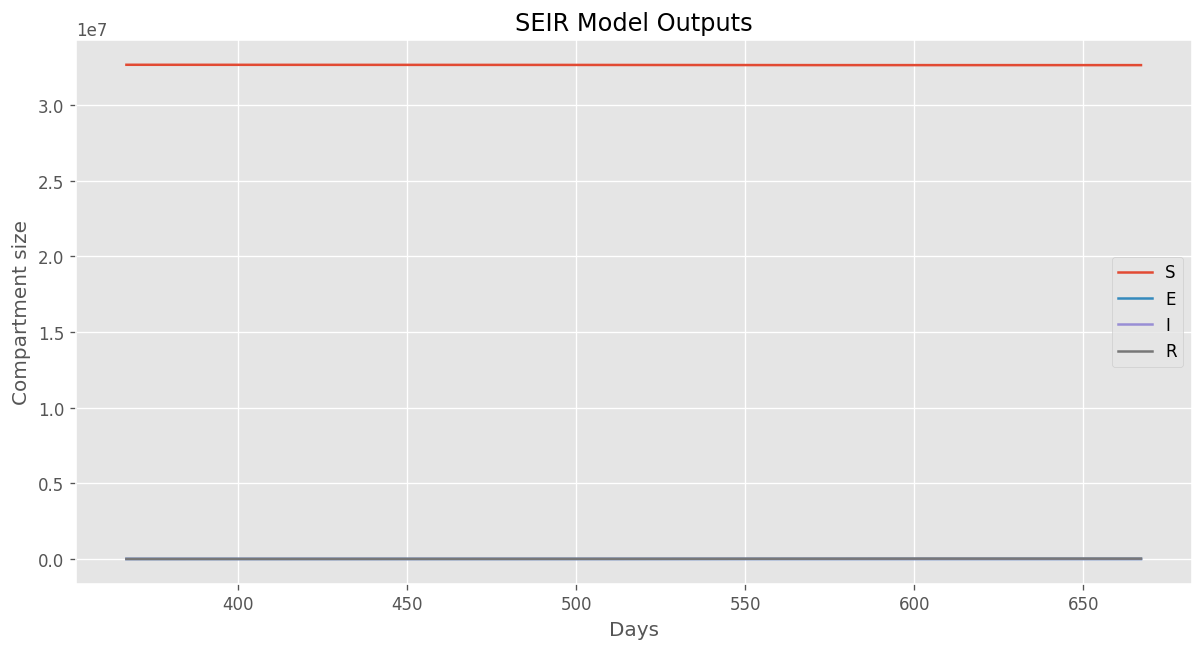

In [15]:
# Visualize the results.
subplot = {"title": "SEIR Model Outputs", "xlabel": "Days", "ylabel": "Compartment size"}
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120, subplot_kw=subplot)

for compartment in mm_outputs_df: # Loop over each compartment. 
    ax.plot(malaysia_model.times, mm_outputs_df[compartment]) # Plot the times and compartment values

ax.legend(["S", "E", "I", "R"]);

In [ ]:
# Let's allow for the fact that case detection is never complete,
# by multiplying the model outputs through by a constant value
proportion_of_cases_detected = 0.05

fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=120)
ax.plot(x_range, target)  # Plot the MoH target values
ax.plot(malaysia_model.times, mm_derived_df["notifications"] * proportion_of_cases_detected);

## Summary

That's it for now, now you know how to:

- Create a model
- Add a population
- Add flows
- Run the model
- Access and visualise the outputs

A detailed API reference for the CompartmentalModel class can be found [here](http://summerepi.com/api/model.html)

The point we reached here is that we have a model that runs and gives some reasonably sensible-looking outputs,
but doesn't match the data we are trying to fit to perfectly.
However, even though this is a mechanistic model of COVID-19 dynamics, 
that is clearly not the only aspect of this model that is unrealistic.
Please reflect on the most important ways in which this very simple model is unrealistic.
There are at least a dozen features of the Malaysian COVID-19 epidemic that aren't captured in this model.
Try listing them out and ordering them according to importance.
How many of these features would you need to include before you were satisfied that this model was something
that could guide policy or be used for prediction?